/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep us

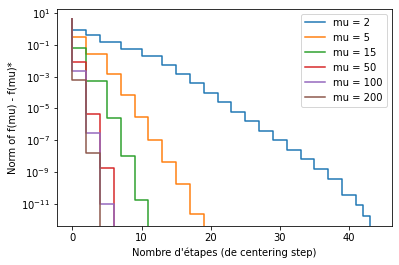

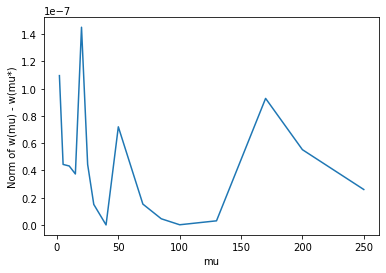

In [2]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.1
beta = 0.7
mu = 5

n = 20
d = 15

eps = 10e-6

lambd = 10


def function(v, Q, p, t0):
    '''
    Valeur de la fonction à optimiser tf + phi
    '''
    return t0*(np.dot(v.T, np.dot(Q, v)) + np.dot(p.T, v)) - sum([np.log(b[i]-np.dot(A[i], v)) for i in range(b.shape[0])])


def function_true(v, Q, p):
    '''
    Valeur de la fonction à optimiser f
    '''
    return np.dot(v.T, np.dot(Q, v)) + np.dot(p.T, v)


def line_search(Q, p, v, t, df, dx, t0):
    '''
    Backtracking line search. Récursif.
    '''
    if function(v + t*dx, Q, p, t0) <= (function(v, Q, p, t0) + alpha*t*np.dot(df.T, dx)) or ((b-A.dot(v+t*dx))>0).all(): #Il faut éviter que le log soit infini.
        return v + t*dx
    else:
        return line_search(Q, p, v, beta*t, df, dx, t0)


def centering_step(Q, p, A, b, t, v0, eps, numb_iter=0):
    '''
    Centering step, calculant les différentes valeurs de gradient de f, le pas x et la valeur lambda carré. Récursif.
    '''
    df = t*(2*np.dot(Q, v0) + p) + \
        sum([A[i, np.newaxis].T/(b[i]-np.dot(A[i], v0)) for i in range(b.shape[0])])
    d2f = 2*t*Q + \
        sum([(np.outer(A[i, np.newaxis].T, A[i, np.newaxis].T)) / ((b[i] - np.dot(A[i], v0))**2) for i in range(b.shape[0])])
    dx = -1*np.dot(np.linalg.inv(d2f), df)
    l2 = np.dot(df.T, np.dot(np.linalg.inv(d2f), df))
    if l2/2 <= eps:
        return v0, numb_iter
    v1 = line_search(Q, p, v0, t=1, df=df, dx=dx, t0=t)
    return centering_step(Q, p, A, b, t, v1, eps, numb_iter+1)


def barr_method_inter(Q, p, A, b, v0, eps, t, mu, numb_iter=0, numb_newton = [], v_seq = [], f_seq_true= []):
    '''
    Fonction récursif de la méthode de la barrière.
    '''
    v_center, numb_iter_inter = centering_step(Q, p, A, b, t, v0, eps)
    numb_newton.append(numb_iter)
    v_seq.append(v_center)
    f_seq_true.append(function_true(v_center, Q, p)[0][0])
    if b.shape[0]/t < eps:
        return v_center, numb_newton, v_seq, f_seq_true
    else:
        t = mu*t
        return barr_method_inter(Q, p, A, b, v0, eps, t, mu, numb_iter+numb_iter_inter, numb_newton, v_seq, f_seq_true)


def barr_method(Q, p, A, b, v0, eps, mu):
    '''
    Fonction de la méthode de la barrière.
    '''
    numb_newton = [0]
    v_seq = [v0]
    f_seq_true = [function_true(v0, Q, p)[0][0]]
    return barr_method_inter(Q, p, A, b, v0, eps, 1, mu, 0, numb_newton, v_seq, f_seq_true)

## Initialisation
X = np.random.rand(n,d)
y = np.random.rand(n,1)
Q = 0.5*np.eye(n)
p = -y
A = np.vstack((X.T,-X.T))
b = lambd*np.ones((2*d,1))

v0 = np.zeros((n,1))

mu_list = [2, 5, 10, 15, 20, 25, 30, 40, 50, 70, 85, 100, 130, 170, 200, 250]
mu_list_restricted = [2, 5, 15, 50, 100, 200]
w_center_list = []
f_true_list = []

## Calcul et plot des résultats
plt.figure()
for mu in mu_list:
    v_center, numb_newton, v_seq, f_seq_true = barr_method(Q, p, A, b, v0, eps, mu)
    w_center = np.linalg.lstsq(X,-v_center-y)[0]
    w_center_list.append(w_center)
    f_true_list.append(f_seq_true[-1])
    if mu in mu_list_restricted:
        plt.step(numb_newton, f_seq_true - f_seq_true[-1], label='mu = '+str(mu))
plt.legend()
plt.ylabel("Norm of f(mu) - f(mu)*")
plt.xlabel("Nombre d'étapes (de centering step)")
plt.semilogy()
plt.show()

## Plot de w en fonction de mu
mu_min = np.argmin(f_true_list)
plt.figure()
w_diff_norm = [np.linalg.norm(w-w_center_list[mu_min]) for w in w_center_list]
plt.plot(mu_list, w_diff_norm)
plt.ylabel("Norm of w(mu) - w(mu*)")
plt.xlabel("mu")
plt.show()